
### **Chapter 6.2: Learning-based Model Predictive Control**

In this chapter, we introduce the motivation and structure of learning-based model predictive control (MPC) under uncertainty. When the true system dynamics are unknown or difficult to model exactly, we rely on data-driven approaches to build approximate models and design robust controllers.

We start by setting up a bumpy terrain case as the simulation environment, and specifying all task parameters. This provides a unified testbed for comparing different control strategies. Then we provide auxiliary functions for basis generation and symbolic model construction. These tools are essential for flexible model learning and controller synthesis. Based on all these preparations, we can develop different controllers and run the simulation according to different level of prior knowledges we know about the real environment, which proceeds through several key stages:

- **Baseline 1:** Simulate MPC designed with the true model (bumpy case) to establish a baseline for performance benchmark.

- **Baseline 2:** Simulate MPC designed with a mismatched model (flat case) and compare with the first example to illustrate the impact of model mismatch.

- **Deterministic learning:** Collect data, identify a deterministic model using **Linear Regression**, and simulate MPC designed with the learned model to demonstrate data-driven control without uncertainty quantification.

- **Probabilistic learning (Robust MPC):** Assume a mismatched model (flat case) and uncertainty bounds and implement **robust MPC (RMPC)** to handle model uncertainty conservatively.

- **Probabilistic learning (Bayesian):** Collect data, identify a probabilistic model using **Bayesian Linear Regression**, and simulate **Learning-based MPC (LBMPC)** with uncertainty quantification, enabling constraint tightening and risk-aware control.

By the end of this chapter, you will understand how to formulate, implement, and analyze both deterministic and probabilistic model learning techniques, and how they integrate into advanced MPC frameworks for uncertain systems.

All the contents are summarized in the table below.  

<table border="1" style="border-collapse: collapse; text-align: center;">
  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 6.2 Exercise</th>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="2">Part 1: Baselines without Uncertainty Handling</td>
    <td>Example 1.1: Baseline MPC under Perfect Model Assumption</td>
  </tr>
  <tr>
    <td>Example 1.2: MPC under Model Mismatch with Flat Terrain Assumption</td>
  </tr>

  <!-- Row group 3 -->
  <tr>
    <td rowspan="1">Part 2: Deterministic Model Learning and Control</td>
    <td>Example 2.1: MPC with Learned Deterministic Model from Data</td>
  </tr>

  <!-- Row group 4 -->
  <tr>
    <td rowspan="2">Part 3: Probabilistic Model Learning and Control</td>
    <td>Example 3.1: Robust MPC with Flat Model and Bounded Uncertainty</td>
  </tr>
  <tr>
    <td>Example 3.2: Learning-Based MPC via Bayesian Model Identification</td>
  </tr>

</table>

<br>

First, we need to set up our Python environment and import relevant packages.

In [96]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

from SysID_utils import GenerateData, Identifier_LR, Identifier_BLR

<br>

### **Experimental Setup and Unified Benchmark for Uncertain Terrain Control**

In this chapter, we address the challenge of controlling a mountain car system when the true environment is uncertain and potentially complex. Specifically, we assume that the real testbed is a bumpy terrain $h(p) = k \cdot \cos(18 p)$ (as case 3 defined before), but as a controller designer, you do not know the exact profile of the terrain. Instead, you are aware that there is some uncertainty in the system dynamics, and your goal is to design controllers that can handle this uncertainty effectively.

To systematically study and compare different control strategies, we establish a unified simulation testbed. This testbed allows us to specify all relevant task parameters and use them consistently across all examples in the chapter. By doing so, we can fairly evaluate the performance of various approaches, from ideal model-based control to learning-based and robust controllers.

- Parameters of simulation:  

   - Case index of testbed: case 3 (bumpy terrain) with parameter $k = 0.01$

   - Control frequency: 10 Hz 

   - Simulation time: 8 seconds

- Parameters of task:  

   - initial state: $\boldsymbol{x}_0 = [-0.5, 0.0]^T$

   - target state: $\boldsymbol{x}_T = [0.5, 0.0]^T$

   - State constraints: $ \quad p \in [-2.0, 2.0], \quad v \in [-4.0, 4.0],$  

   - Input constraints: $ \quad a \in [-8.0, 8.0],$  

- Parameters of controller:  

   - Prediction horizon: $N = 20$
   
   - State cost matrix: $\boldsymbol{Q} = diag([5, 5])$  

   - Input cost matrix: $\boldsymbol{R} = 0.1$  

   - Terminal cost matrix: $\boldsymbol{Q}_f = \boldsymbol{Q}$ 


These parameters define the environment and control objectives for all subsequent simulations and experiments in this chapter.

In [97]:
# Define the test case
case_real = 3

# Define the parameters of the slope
terrain_param = 0.01

# Define task parameters
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.5
target_velocity = 0.0

# Define the physical boundary condition
state_lbs = np.array([-2.0, -4.0])
state_ubs = np.array([2.0, 4.0])
input_lbs = -8.0
input_ubs = 8.0

# Define the parameters in the controller
N = 20
Q = np.diag([5, 5])
R = np.array([[0.1]])
Qf = Q

# Define parameters for simulation
freq = 10 # controll frequency
t_terminal = 8 # time length of simulation

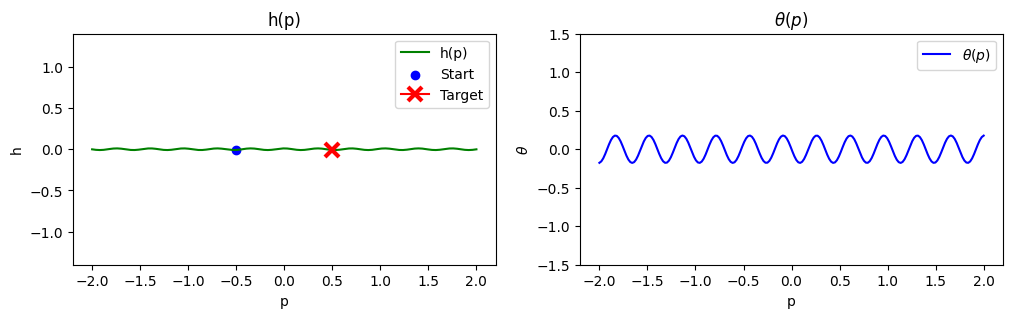

In [98]:
# Instantiate class 'Env'
env_real = Env(case_real, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
          param=terrain_param, state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)
env_real.test_env()

# Instantiate class 'Dynamics'
dynamics_real = Dynamics(env_real)

<br>

### **Auxiliary Functions for Generating the Symbolic Expression of Identifed Model**

The first utility function **`generate_basis_functions`** simplifies the construction of basis sets for regression by allowing you to automatically generate combinations of polynomial and trigonometric functions with configurable orders and frequencies.  

**Arguments:**  

- `include_offset`: Whether to include the constant bias term $ \phi(p) = 1 $

- `include_polynomial`: Whether to include polynomial terms $ p^i $

- `include_trigonometric`: Whether to include trigonometric terms $ \sin(k p) $, $ \cos(k p) $

- `min_poly_order`, `max_poly_order`: Range of polynomial degrees $ i $

- `min_freq`, `max_freq`: Range of trigonometric frequencies $ k $

- `casadi_sym`: Whether to generate CasADi symbolic expressions of the basis functions

**Returns:**  

- `basis`: List of callable basis functions $\{ \phi_1(p), ... , \phi_B(p) \}$. Each basis function accepts a NumPy array of shape `(D, 1)` or `(D,)` and returns a transformed column vector of shape `(D, 1)`.

- `p_sym`: Symbolic variable (later used in construnction of the symbolic identified model)  

- `basis_syms`: List of symbolic expressions of the basis functions $\{ \phi_1(p), ... , \phi_B(p) \}$ (later used in construnction of the symbolic identified model)  

In [99]:
def generate_basis_functions(include_offset=True,
                              include_polynomial=True,
                              include_trigonometric=True,
                              min_poly_order=1,
                              max_poly_order=10,
                              min_freq=1,
                              max_freq=10,
                              casadi_sym=True):
    
    """
    Generate a list of basis functions for use in linear regression or Bayesian regression.

    Parameters:
    - include_offset: whether to include the constant 1 term
    - include_polynomial: whether to include polynomial terms p^i
    - include_trigonometric: whether to include sin(kp) and cos(kp) terms
    - min_poly_order: lowest polynomial degree to include
    - max_poly_order: highest polynomial degree to include
    - min_freq: lowest frequency k for trig functions
    - max_freq: highest frequency k for trig functions
    - casadi_sym: if set to be True, use this symbolic variable for generating symbolic basis functions (basde on CasADi)

    Returns:
    - basis: a list of callable functions, each \\phi(\\xi) taking \\xi as (D, 1) or (D,) array
    - basis_syms: a list of symbolic expressions for each basis function, if casadi_sym is provided, else None
    """
    
    basis = []
    # If using symbolic computation with CasADi, initialize symbolic variables
    if casadi_sym:
        p_sym = ca.MX.sym("p")
        basis_syms = []
    else:
        basis_syms = None

    # Offset term
    if include_offset:
        basis.append(lambda p: np.ones_like(p))
        # If using symbolic computation with CasADi, add the symbolic constant
        if casadi_sym:
            basis_syms.append(1)

    # Polynomial terms
    if include_polynomial:
        for i in range(min_poly_order, max_poly_order + 1):
            basis.append(lambda p, i=i: p**i)
        # If using symbolic computation with CasADi, add the symbolic polynomial terms
        if casadi_sym:
            for i in range(min_poly_order, max_poly_order + 1):
                basis_syms.append(p_sym ** i)

    # Trigonometric terms
    if include_trigonometric:
        for k in range(min_freq, max_freq + 1):
            basis.append(lambda p, k=k: np.sin(k * p))
            basis.append(lambda p, k=k: np.cos(k * p))
        # If using symbolic computation with CasADi, add the symbolic trigonometric terms
        if casadi_sym:
            for k in range(min_freq, max_freq + 1):
                basis_syms.append(ca.sin(k * p_sym))
                basis_syms.append(ca.cos(k * p_sym))

    return basis, p_sym, basis_syms

<br>

The second function **`construct_casadi_expression`** constructs a CasADi symbolic function for the learned model, combining basis functions and regression weights. It can also provide a function for the predictive variance if uncertainty information is available.  

**Arguments:**  

- `p_sym`: CasADi symbolic variable of independent variable $p$ 

- `basis_syms`: List of symbolic basis expressions $\{ \phi_1(p), ... , \phi_B(p) \}$

- `theta`: Regression weights $\hat{\mu}_\theta$ (attained from **LR** or **BLR**)

- `Sigma_theta` (only for **BLR**): Covariance of weights $\hat{\Sigma}_\theta$ (attained from **BLR**)

- `sigma2_prior` (only for **BLR**): Prior noise variance $\sigma^2$

**Returns:**  

- `h_func`: CasADi function for the mean prediction $\hat{\mu}_{h}(p^*) = \hat{\mu}_\theta^\top \phi(p^*)$

- `sigma2_h` (only for **BLR**): CasADi function for the predictive variance matirx $\hat{\sigma}^2_{h}(p^*) = \sigma^2 + \phi(p^*)^\top \hat{\Sigma}_\theta \phi(p^*)$
    

In [100]:
def construct_casadi_expression(p_sym, basis_syms, theta, Sigma_theta=None, sigma2_prior=None):
    """
    Construct a CasADi symbolic function for h(p) = sum_i theta_i * phi_i(p)

    Parameters:
    - p_sym: CasADi symbolic variable representing the input
    - theta: numpy array of shape (D, 1) or (D,) from Identifier_LR
    - basis_syms: list of CasADi symbolic expressions for each basis function
    - Sigma_theta: optional covariance matrix for Bayesian regression (D, D)
    - sigma2_prior: optional prior variance for Bayesian regression (scalar)

    Returns:
    - h_expr: CasADi symbolic expression
    - p_sym: CasADi symbolic variable
    - h_func: CasADi Function that maps p → h(p)
    """
    
    # Ensure basis_syms is concatenated into a vector expression
    Phi_sym = ca.vertcat(*basis_syms)

    # Compute h(p) expression
    h_expr = ca.dot(Phi_sym, theta)  # same as sum(theta[i] * phi_i)

    # Define CasADi function for mean
    h_func = ca.Function("h_post", [p_sym], [h_expr])

    # Define CasADi function for variance if required
    if Sigma_theta is not None and sigma2_prior is not None:
        Sigma_expr = ca.mtimes([Phi_sym.T, ca.DM(Sigma_theta), Phi_sym]) + ca.DM(sigma2_prior)
        sigma2_h = ca.Function("sigma2_h_post", [p_sym], [Sigma_expr])
    else:
        sigma2_h = None

    return h_func, sigma2_h

<br>

----

### **Part 1: Baselines without Uncertainty Handling**

To understand the necessity of handling model uncertainty in control design, we begin by establishing baseline scenarios where uncertainty is either absent or ignored. In this part, we first examine the ideal case where the controller has full knowledge of the true environment, serving as an upper bound for performance. We then contrast this with a naive design that assumes a simplified, mismatched model, revealing the degradation in performance that arises when uncertainty is neglected. These baselines provide valuable context for evaluating the benefits of more sophisticated, uncertainty-aware controllers in subsequent sections.

<br>

#### **Example 1.1: Baseline MPC under Perfect Model Assumption**

In this example, we assume full knowledge of the true terrain profile. We simulate MPC designed with the true model (case 3) to establish a baseline for performance benchmark. This serves as the ideal scenario, providing a reference for evaluating the impact of model mismatch and learning-based approaches in subsequent examples.

In [ ]:
# Define the MPC controller
controller_mpc_ideal = MPCController(env_real, dynamics_real, Q, R, Qf, freq, N, name='MPC_baseline', verbose=False)

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc_ideal = Simulator(dynamics_real, controller_mpc_ideal, env_real, 1/freq, t_terminal)
simulator_mpc_ideal.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc_ideal = Visualizer(simulator_mpc_ideal)
visualizer_mpc_ideal.display_plots("Baseline MPC under Perfect Model Assumption")
visualizer_mpc_ideal.display_animation()

field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_baseline_20250909_102805.so
rm -f acados_solver_MPC_baseline_20250909_102805.o
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o acados_solver_MPC_baseline_20250909_102805.o acados_solver_MPC_baseline_20250909_102805.c


<br>

#### **Example 1.2: MPC under Model Mismatch with Flat Terrain Assumption**

In this example, we consider the scenario where the controller designer does not have access to the true terrain profile. Instead, the designer assumes a **simplified, flat terrain model** (case 1) for controller synthesis. We simulate MPC designed with this mismatched (flat) model and apply it to the real bumpy environment. By comparing the results with the ideal baseline (where the true model is known), we can clearly illustrate the impact of model mismatch on control performance and highlight the necessity of accounting for model uncertainty in practical applications.

In [ ]:
case_ideal = 1 # 1 or 2 or 3 or 4

# Ideal case for controller design
env_ideal = Env(case_ideal, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
                 param=terrain_param, state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)
dynamics_ideal = Dynamics(env_ideal)


field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_flat_terrain_model_20250909_102750.so
rm -f acados_solver_MPC_flat_terrain_model_20250909_102750.o
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o acados_solver_MPC_flat_terrain_model_20250909_102750.o acados_solver_MPC_flat_terrain_model_20250909_102750.c
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o MPC_flat_terrain_model_20250909_102750_model/MPC_flat_terrain_model_20250909_102750_expl_ode_fun.o MPC_flat_terrain_model_20250909_102750_model/MPC_flat_terrain_model_20250909_102750_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/inc

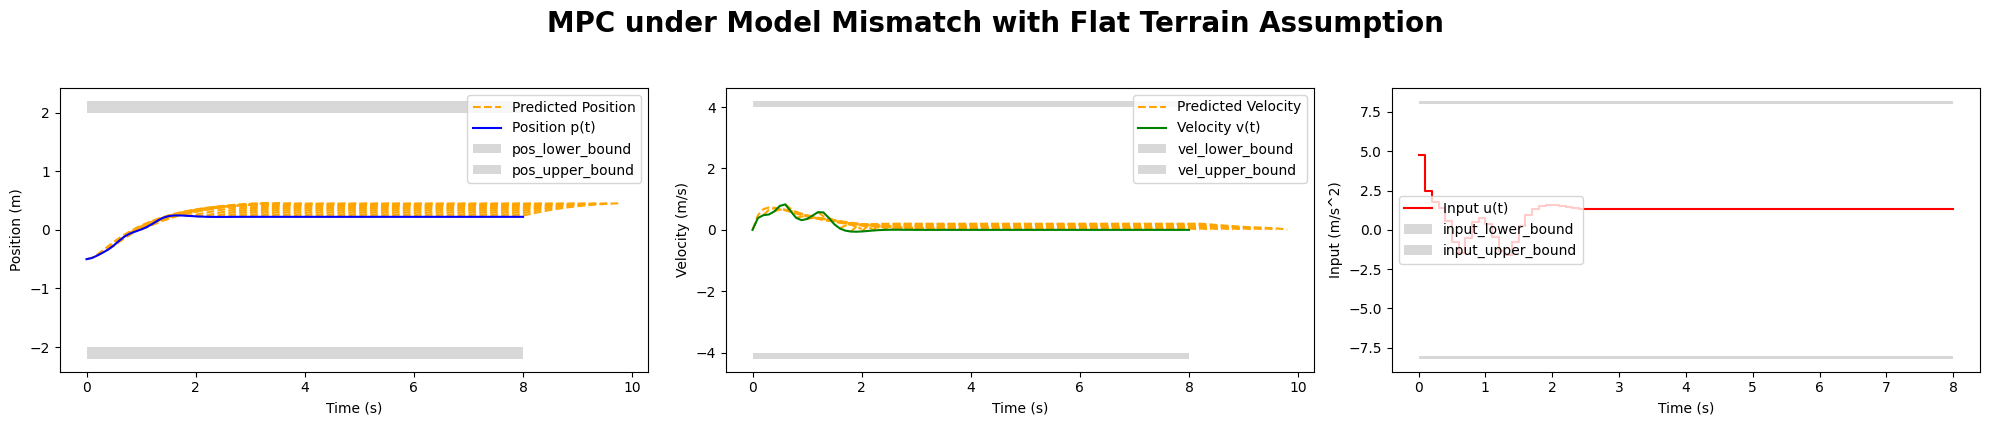

In [ ]:
# Define the MPC controller
controller_mpc_real = MPCController(env_ideal, dynamics_ideal, Q, R, Qf, freq, N, name='MPC_flat_terrain_model', verbose=False)

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc_real = Simulator(dynamics_real, controller_mpc_real, env_real, 1/freq, t_terminal)
simulator_mpc_real.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc_real = Visualizer(simulator_mpc_real)
visualizer_mpc_real.display_plots("MPC under Model Mismatch with Flat Terrain Assumption")
visualizer_mpc_real.display_animation()


#### **Results Analysis**

In the ideal case without model mismatch, the system accurately follows the predicted trajectory and successfully reaches the target state with smooth and efficient control. In contrast, with model mismatch, the predicted and actual states deviate noticeably—especially in position—and the system fails to converge to the target. The control inputs become more aggressive, highlighting the negative impact of model inaccuracies on performance.

<br>

----

### **Part 2: Deterministic Model Learning and Control**

In this part, we consider the scenario where the true system dynamics are unknown, but we have the ability to collect data from the environment and use it to learn an approximate deterministic model. We demonstrate how to use linear regression with carefully chosen basis functions to identify the terrain profile, and then synthesize an MPC controller based on the learned model. This section highlights the workflow of data-driven control, showing how model identification from data can enable effective control even without perfect prior knowledge of the system.

<br>

#### **Example 2.1: MPC with Learned Deterministic Model from Data**

We proceed by first collecting input-output samples from the real environment (case 3 with a specified terrain parameter $k$), where the measurements are affected by additive Gaussian noise $w_k \sim \mathcal{N}(0, \sigma^2 I)$. This dataset serves as the basis for model identification. To flexibly approximate the unknown terrain profile, we select a set of basis functions consisting of trigonometric terms—specifically sine and cosine functions with frequencies ranging from 16 to 20—and include a constant offset. Polynomial terms are excluded to better capture the periodic nature of the terrain. Using a standard Linear Regression (LR) approach, we fit the collected data to these basis functions, yielding a deterministic approximation of the terrain. Finally, this learned model is embedded into the MPC framework and evaluated in the true environment to assess its closed-loop performance.

- **Reference Arguments for Basis function configuration:**

    - Include offset: `True`

    - Include polynomial terms: `False`

    - Include trigonometric terms: `True`

    - Minimum frequency: `16`

    - Maximum frequency: `20`

- **Reference Arguments for Data generation:**

    - Number of samples: `100`

    - Measurement noise: zero-mean Gaussian, standard deviation $\sigma$ as `0.005`


In [ ]:
# Define basis functions
include_offset=True
include_polynomial=False
include_trigonometric=True
min_poly_order=1
max_poly_order=1
min_freq=16
max_freq=20

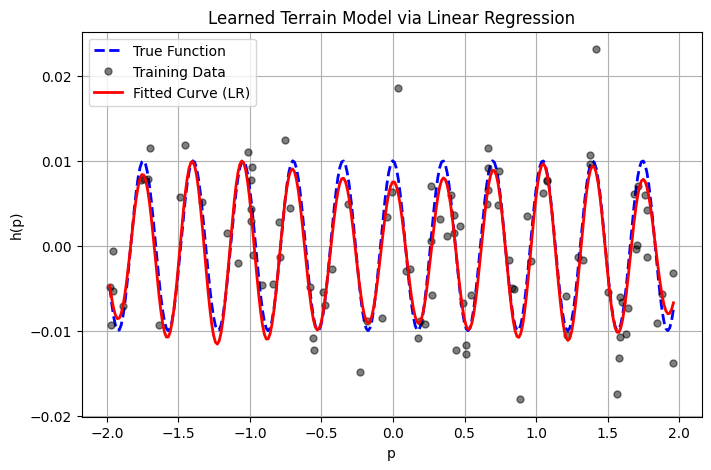

In [ ]:
# Generate the training data
np.random.seed(49) # for reproducibility
data_gen = GenerateData(num_samples=100, case=case_real, param=terrain_param)
data_gen.set_noise(mean=0.0, std=0.005) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Generate basis functions
basis, p_sym, basis_sym = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, 
                                                   min_poly_order, max_poly_order, min_freq, max_freq)

# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title="Learned Terrain Model via Linear Regression")


# Generate the symbolic expression for the learned model
h_func_lr, _ = construct_casadi_expression(p_sym, basis_sym, model_lr.theta)

In [ ]:
# Real case for simulation
env_id = Env(case_real, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
                 symbolic_h_mean_ext=h_func_lr, param=terrain_param, 
                 state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)
dynamics_id = Dynamics(env_id)

field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_identified_20250909_102754.so
rm -f acados_solver_MPC_identified_20250909_102754.o
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o acados_solver_MPC_identified_20250909_102754.o acados_solver_MPC_identified_20250909_102754.c
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o MPC_identified_20250909_102754_model/MPC_identified_20250909_102754_expl_ode_fun.o MPC_identified_20250909_102754_model/MPC_identified_20250909_102754_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o MPC_identified_20250

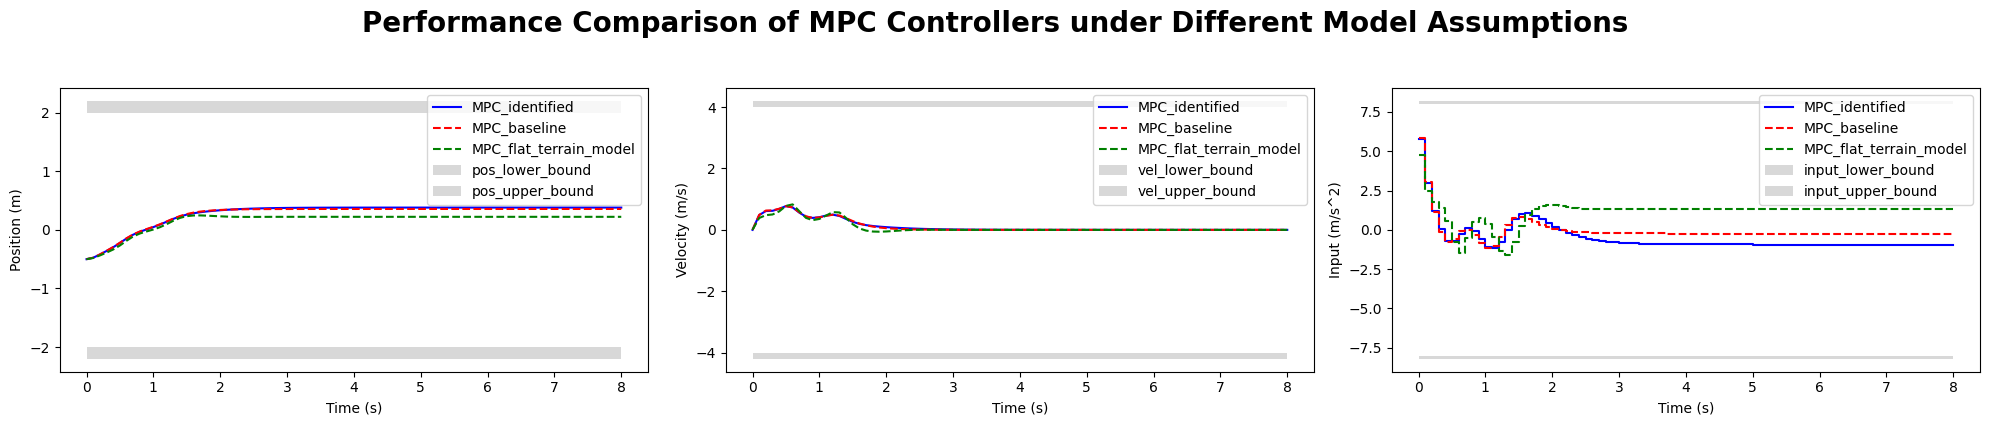

In [ ]:
# Define the MPC controller
controller_mpc_identified = MPCController(env_id, dynamics_id, Q, R, Qf, freq, N, name='MPC_identified', verbose=False)

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc_identified = Simulator(dynamics_real, controller_mpc_identified, env_real, 1/freq, t_terminal)
simulator_mpc_identified.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc_identified = Visualizer(simulator_mpc_identified)
visualizer_mpc_identified.display_contrast_plots(simulator_mpc_ideal, simulator_mpc_real, title='Performance Comparison of MPC Controllers under Different Model Assumptions')
visualizer_mpc_identified.display_contrast_animation_same(simulator_mpc_ideal, simulator_mpc_real)

#### **Results Analysis**

The simulation result highlights the performance of the MPC controller using an identified model (blue) compared to the ideal model (red) and a mismatched flat model (green). The identified controller achieves nearly the same tracking accuracy and control efficiency as the ideal case, demonstrating that a well-learned model from data can effectively recover high performance. In contrast, the flat model leads to steady-state error and larger inputs due to model mismatch.

<br>

----

### **Part 3: Probabilistic Model Learning and Control**

In this section, we address the challenge of controlling systems under uncertainty by leveraging probabilistic model learning and robust control strategies. Unlike previous parts where either the true model or a deterministic learned model was used, here we explicitly account for model uncertainty—either by assuming bounded disturbances or by learning a probabilistic model from data. We first demonstrate robust MPC (RMPC) using a mismatched flat model with relatively large uncertainty bounds, and then introduce Bayesian Linear Regression to quantify model uncertainty and enable Learning-Based MPC (LBMPC) with constraint tightening.

<br>

#### **Example 3.1: Robust MPC with Flat Model and Bounded Uncertainty**

In this example, we assume the controller designer does not know the true terrain profile and instead simplifies it as flat. However, unlike previous cases that ignore the modeling error, here we explicitly consider that the mismatch between the flat model and reality is bounded. We specify a box-type disturbance set with:

$$
w_1 \in \mathcal{D}_1 = [-0.4, 0.4], \quad w_2 \in \mathcal{D}_2 = [-0.8, 0.8]
$$

representing prior belief on how much the unmodeled dynamics can deviate. With this uncertainty set, we design a **Robust MPC (RMPC)** controller that tightens the constraints based on worst-case disturbance propagation. This ensures that safety constraints are satisfied at all times, even in the presence of the assumed disturbance. The resulting controller is then evaluated in the real bumpy environment to assess performance under model uncertainty.


field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_RMPC_flat_terrain_model_20250909_102759.so
rm -f RMPC_flat_terrain_model_20250909_102759_constraints/RMPC_flat_terrain_model_20250909_102759_constr_h_0_fun_jac_uxt_zt.o RMPC_flat_terrain_model_20250909_102759_constraints/RMPC_flat_terrain_model_20250909_102759_constr_h_0_fun.o RMPC_flat_terrain_model_20250909_102759_constraints/RMPC_flat_terrain_model_20250909_102759_constr_h_fun_jac_uxt_zt.o RMPC_flat_terrain_model_20250909_102759_constraints/RMPC_flat_terrain_model_20250909_102759_constr_h_fun.o RMPC_flat_terrain_model_20250909_102759_constraints/RMPC_flat_terrain_model_20250909_102759_constr_h_e_fun_jac_uxt_zt.o RMPC_flat_terrain_model_20250909_102759_constraints/RMPC_flat_terrain_model_20250909_102759_constr_h_e_fun.o acados_solver_RMPC_flat_terrain_model_20250909_102759.o

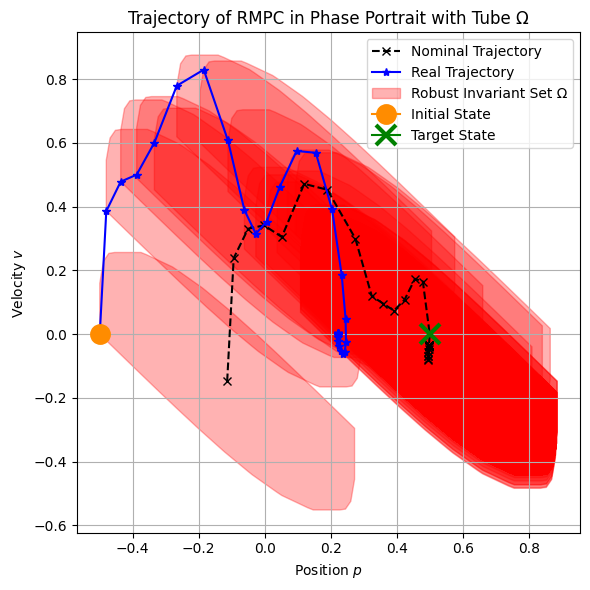

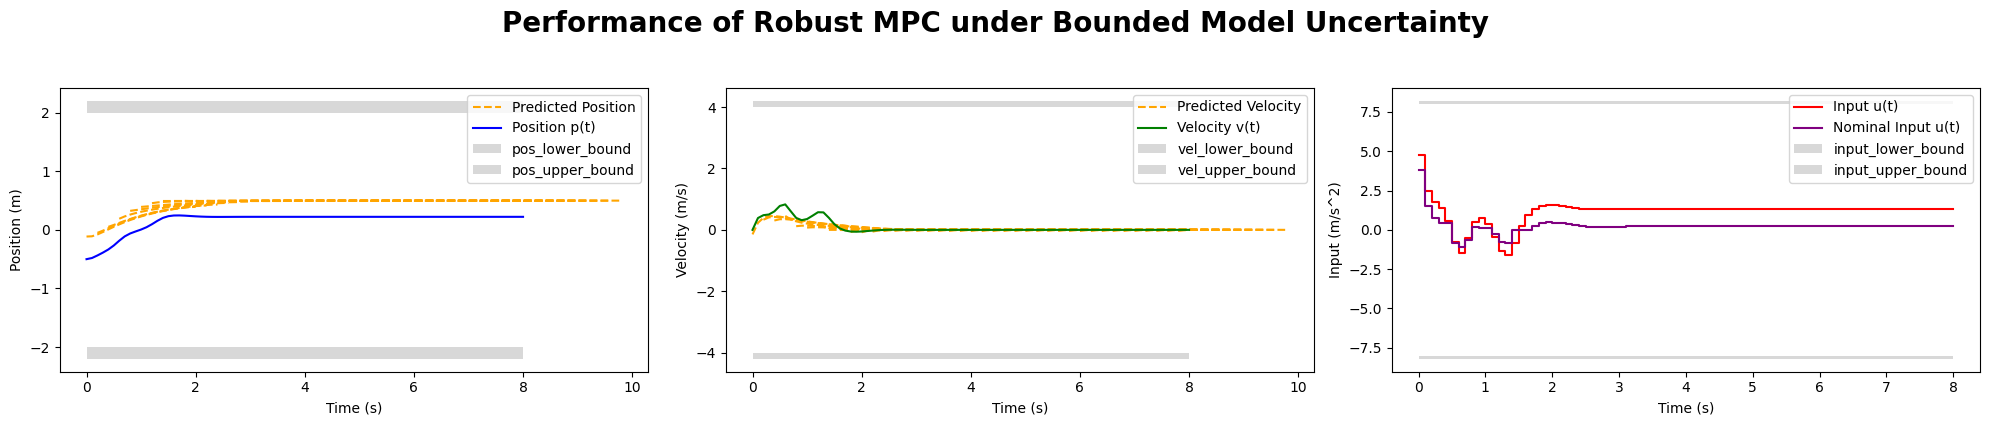

KeyboardInterrupt: 

In [ ]:
# Define the bounds for the disturbances
disturbance_lbs = np.array([-0.4, -0.8])
disturbance_ubs = np.array([0.4, 0.8])

# Define the RMPC controller
controller_rmpc = LinearRMPCController(env_ideal, dynamics_ideal, Q, R, Qf, freq, N, 
                                       disturbance_bounds=[disturbance_lbs, disturbance_ubs], max_iter=10, name = 'RMPC_flat_terrain_model', verbose=False)

# Instantiate the simulator, run the simulation, and plot the results
simulator_rmpc = Simulator(dynamics_real, controller_rmpc, env_real, 1/freq, t_terminal)
simulator_rmpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_rmpc = Visualizer(simulator_rmpc)
visualizer_rmpc.display_phase_portrait()
visualizer_rmpc.display_plots("Performance of Robust MPC under Bounded Model Uncertainty")
visualizer_rmpc.display_animation()

#### **Results Analysis**

In this example, the nominal state trajectory successfully converges to the target position, demonstrating that the RMPC optimization works as intended under the assumed flat model. However, due to the presence of the robust invariant tube, the true state is only guaranteed to stay within a neighborhood around the nominal trajectory. Since the stabilizing feedback controller was designed based on the flat terrain dynamics, it may not generate sufficient corrective inputs on the actual sloped terrain to drive the true state exactly to the target. As a result, we observe a steady-state error in the true trajectory. This illustrates a key limitation of RMPC: while it ensures constraint satisfaction and robustness, it may fail to achieve precise convergence in the presence of unmodeled dynamics.

<br>

#### **Example 3.2: Learning-Based MPC via Bayesian Model Identification**

In this example, we address the problem of controlling a system when the true environment is unknown and potentially complex, such as a bumpy terrain profile. Instead of assuming a fixed disturbance bound (as in RMPC), we collect data and apply **Bayesian Linear Regression (BLR)** to learn a **probabilistic model** of the terrain, capturing both the mean and the uncertainty of the terrain profile $ h(p) $. This learned probabilistic model is then integrated into an MPC framework. The core idea is to use the **mean prediction** of the BLR model to correct the dynamics and use the **predicted variance** to perform **constraint tightening**, ensuring that state constraints are satisfied with high probability.

We begin by assuming the system dynamics can be written as:

$$
\dot{x} = \bar{f}(x, u) + \mu^{\text{LM}}(x, u) + w
$$

where:

- $ \bar{f}(x, u) $: prior nominal dynamics,

- $ \mu^{\text{LM}}(x, u) $: learned mean correction from the BLR model,

- $ w \sim \mathcal{N}(0, \Sigma^w) $: zero-mean Gaussian process noise.

&nbsp;&nbsp;&nbsp;&nbsp;*Note that: here we do not use a prior model, but directly identify the whole dynamcis, i.e.: $\bar{f}(x, u) = 0$ .*

To implement Learning-Based MPC, we discretize the above and define the predicted mean state as:

$$
\mu^{x}_{k+i+1|k} = \bar{f}(\mu^{x}_{k+i|k}, u_{k+i|k}) + \mu^{\text{LM}}(\mu^{x}_{k+i|k}, u_{k+i|k})
$$

This gives us the **deterministic state prediction** based on both prior knowledge and the learned mean correction.


To safely handle constraints under uncertainty, we **propagate the state covariance** across the prediction horizon. Using first-order uncertainty propagation, the covariance is updated as:

$$
\Sigma^{x}_{k+i+1|k} = 
\left[
\begin{array}{cc}
\nabla^{\top}_{x} \bar{f}(\mu^{x}_{k+i|k}, u_{k+i|k}) & \mathbf{I}
\end{array}
\right]
\left[
\begin{array}{cc}
\Sigma^{x}_{k+i|k} & \star \\
\nabla_{x} \mu^{\text{LM}} (\mu^{x}_{k+i|k}, u_{k+i|k}) \Sigma^{x}_{k+i|k}  & \Sigma^{\text{LM}}(\mu^{x}_{k+i|k}, u_{k+i|k}) + \Sigma^{w}
\end{array}
\right]
\left[
\begin{array}{c}
\nabla_{x} \bar{f}(\mu^{x}_{k+i|k}, u_{k+i|k}) \\
\mathbf{I}
\end{array}
\right]
$$

where $ \Sigma^{\text{LM}} $ is the learned covariance from BLR.


We then use this covariance to perform **constraint tightening**. Let the original state constraint set be $ \mathcal{X} $. Consider the uncertainty set $\mathcal{R}^x$ as:

$$
\mathcal{R}^x = \left\{ x \in \mathbb{R}^n : |[e^x_i]|_j < r \sqrt{[\Sigma^x]_{j,j}}, \quad \forall j = 1, \dots, n \right\}
$$

which defines a high-probability ellipsoidal confidence region around the predicted mean. The final **tightened constraint** for use in MPC is:

$$
\mu^x_{k+i|k} \in \mathcal{X} \ominus \mathcal{R}^x
$$

This ensures that the true state lies within the original constraint set with high probability (e.g., $ p_x = 0.997 $ when $ r = 3 $).


Finally, we formulate the deterministic LBMPC problem as:

$$
\min_{u_{k|k}, \dots, u_{k+N-1|k}} \ell_N(\mu^x_{k+N|k}) + \sum_{i=0}^{N-1} \ell_i(\mu^x_{k+i|k}, u_{k+i|k})
$$

subject to:

$$
\mu^{x}_{k+i+1|k} = \bar{f}(\mu^x_{k+i|k}, u_{k+i|k}) + \mu^{\text{LM}}(\mu^x_{k+i|k}, u_{k+i|k}), \quad \forall i = \{0, 1, ..., N-1\},
$$
$$
\Sigma^{x}_{k+i+1|k} \leftarrow \text{ updated via the first-order approximation}
$$
$$
\mu^x_{k+i|k} \in \mathcal{X} \ominus \mathcal{R}^x(\Sigma^x_{k+i|k}), \quad \forall i = \{0, 1, ..., N-1\},
$$
$$
u_{k+i|k} \in \mathcal{U}, \quad \forall i = \{0, 1, ..., N-1\},
$$
$$
\mu^x_{k|k} = x_k, \quad \Sigma^x_{k|k} = 0.
$$


Through this setup, **LBMPC** ensures that both prediction and control account for model uncertainty, leading to improved safety and reduced conservatism compared to RMPC. The learned uncertainty from BLR drives the tightening, allowing a **data-efficient and probabilistically safe** control solution. We implement this data-driven controller as the class following:

In [ ]:
class LearningBasedMPCController(LQRController):
    def __init__(self, 
                 env, 
                 dynamics, 
                 Q, 
                 R, 
                 Qf, 
                 N, 
                 freq, 
                 beta=3.0, 
                 Sigma_w=None, 
                 name='LBMPC',
                 type: str = 'MPC', 
                 verbose: bool = True):

        self.Qf = Qf
        self.N = N
        self.beta = beta # default for beta is 3.0, which corresponds to 3-sigma rule

        super().__init__(env, dynamics, Q, R, freq, name, type, verbose)

        if self.env.h_cov is None:
            raise ValueError("Dynamics variance function must be provided for LBMPC.")
        else:
            self.dynamics.build_stochastic_model(self.dt)

        self.Sigma_w = Sigma_w if Sigma_w is not None else np.zeros((self.dim_states, self.dim_inputs))

    def setup(self):

        ## Model
        # Set up Acados model
        model = AcadosModel()
        model.name = self.name

        # Define model: x_dot = f(x, u)
        model.x = self.dynamics.states
        model.u = self.dynamics.inputs
        model.f_expl_expr = ca.vertcat(self.dynamics.dynamics_function(self.dynamics.states, self.dynamics.inputs))
        model.f_impl_expr = None # no needed, we already have the explicit model

        ocp = AcadosOcp()
        ocp.model = model
        ocp.dims.N = self.N
        ocp.solver_options.tf = self.N * self.dt
        ocp.solver_options.qp_solver = "FULL_CONDENSING_HPIPM"
        ocp.solver_options.integrator_type = "ERK"
        ocp.solver_options.nlp_solver_type = "SQP"

        # Set up other hyperparameters in SQP solving
        ocp.solver_options.nlp_solver_max_iter = 100
        ocp.solver_options.nlp_solver_tol_stat = 1E-6
        ocp.solver_options.nlp_solver_tol_eq = 1E-6
        ocp.solver_options.nlp_solver_tol_ineq = 1E-6
        ocp.solver_options.nlp_solver_tol_comp = 1E-6

        ocp.cost.cost_type = "LINEAR_LS"
        ocp.cost.cost_type_e = "LINEAR_LS"

        ocp.cost.W = np.block([
            [self.Q, np.zeros((self.dim_states, self.dim_inputs))],
            [np.zeros((self.dim_inputs, self.dim_states)), self.R]
        ])
        ocp.cost.W_e = self.Qf

        ocp.cost.Vx = np.block([
            [np.eye(self.dim_states)],
            [np.zeros((self.dim_inputs, self.dim_states))]
        ])
        ocp.cost.Vu = np.block([
            [np.zeros((self.dim_states, self.dim_inputs))],
            [np.eye(self.dim_inputs)]
        ])
        ocp.cost.Vx_e = np.eye(self.dim_states)

        ocp.cost.yref = np.zeros(self.dim_states + self.dim_inputs)
        ocp.cost.yref_e = np.zeros(self.dim_states)

        # Define constraints
        ocp.constraints.idxbx_0 = np.arange(self.dim_states)
        ocp.constraints.idxbx = np.arange(self.dim_states)
        ocp.constraints.idxbx_e = np.arange(self.dim_states)
        ocp.constraints.idxbu = np.arange(self.dim_inputs)
        
        ocp.constraints.lbx_0 = np.array(self.env.state_lbs)
        ocp.constraints.ubx_0 = np.array(self.env.state_ubs)
        ocp.constraints.lbx = np.array(self.env.state_lbs)
        ocp.constraints.ubx = np.array(self.env.state_ubs)
        ocp.constraints.lbx_e = np.array(self.env.state_lbs)
        ocp.constraints.ubx_e = np.array(self.env.state_ubs)
        ocp.constraints.lbu = np.array(self.env.input_lbs)
        ocp.constraints.ubu = np.array(self.env.input_ubs)

        self.ocp = ocp
        self.solver = AcadosOcpSolver(ocp, json_file=f"{self.name}.json")

    def propagate_uncertainty(self, x, u, Sigma_curr):
        Sigma_next = self.dynamics.dynamics_variance_function_disc(x, u) + self.Sigma_w
        return Sigma_next

    def tighten_state_constraints(self, Sigma_x):
        r = self.beta
        diag = np.sqrt(np.diag(Sigma_x))
        if self.verbose:
            print(f"Tightening state constraints with beta={self.beta}, diag={diag}")
        return self.env.state_lbs + r * diag, self.env.state_ubs - r * diag

    def compute_action(self, current_state: np.ndarray, current_time):
        self.solver.set(0, "lbx", current_state)
        self.solver.set(0, "ubx", current_state)

        # === Step 1: Use previous rollout to predict mean state/control sequence ===
        mu_x_seq = [current_state]
        mu_u_seq = []

        for i in range(self.N):
            # Use last solved control prediction if available, otherwise use zeros
            if hasattr(self, "last_u_pred"):
                mu_u = self.last_u_pred[i]
            else:
                mu_u = np.zeros(self.dim_inputs)
            mu_x = mu_x_seq[-1]

            # Compute next state mean via dynamics
            mu_x_next = self.dynamics.one_step_forward(mu_x, mu_u, self.dt)  # should match rollout model
            mu_x_seq.append(mu_x_next)
            mu_u_seq.append(mu_u)

        # === Step 2: Propagate uncertainty along predicted trajectory ===
        Sigma_x_seq = [np.zeros((self.dim_states, self.dim_states))]

        for i in range(self.N):
            Sigma_x_next = self.propagate_uncertainty(
                mu_x_seq[i], mu_u_seq[i], Sigma_x_seq[i]
            )
            Sigma_x_seq.append(Sigma_x_next)

        # === Step 3: Apply constraint tightening and set to Acados ===
        ref = np.concatenate((self.env.target_state, np.zeros(self.dim_inputs)))
        for i in range(1, self.N):
            # Set reference
            self.solver.set(i, "yref", ref)

            # # Tighten constraints based on propagated covariance
            lbx_tight, ubx_tight = self.tighten_state_constraints(Sigma_x_seq[i])
            self.solver.set(i, "lbx", lbx_tight)
            self.solver.set(i, "ubx", ubx_tight)
            if self.verbose:
                print(f"Step {i}: lbx={lbx_tight}, ubx={ubx_tight}")

        self.solver.set(self.N, "yref", self.env.target_state)
        lbx_tight, ubx_tight = self.tighten_state_constraints(Sigma_x_seq[self.N])
        self.solver.set(self.N, "lbx", lbx_tight)
        self.solver.set(self.N, "ubx", ubx_tight)
        if self.verbose:
            print(f"Final step: lbx={lbx_tight}, ubx={ubx_tight}")

        # === Step 4: Solve MPC ===
        status = self.solver.solve()
        #if status != 0:
        #    raise ValueError(f"Acados solver failed with status {status}")

        u_opt = self.solver.get(0, "u")
        x_pred = np.array([self.solver.get(i, "x") for i in range(self.N + 1)])
        u_pred = np.array([self.solver.get(i, "u") for i in range(self.N)])

        # Cache rollout for next time
        self.last_u_pred = u_pred.copy()
        self.last_x_pred = x_pred.copy()

        return u_opt, x_pred, u_pred

We instantiate the learning-based MPC method developed above and evaluate its performance through simulation. The parameter settings used in the system identification phase are listed below.

- **Reference Arguments for Basis function configuration:**

    - Include offset: `True`

    - Include polynomial terms: `False`

    - Include trigonometric terms: `True`

    - Minimum frequency: `16`

    - Maximum frequency: `20`

- **Reference Arguments for Data generation:**

    - Number of samples: `1000`

    - Measurement noise: zero-mean Gaussian, standard deviation $\sigma$ as `0.005`

In [ ]:
# Define the prior parameters
sigma_prior = 0.005

# Define basis functions
include_offset=True
include_polynomial=False
include_trigonometric=True
min_poly_order=1
max_poly_order=1
min_freq=16
max_freq=20

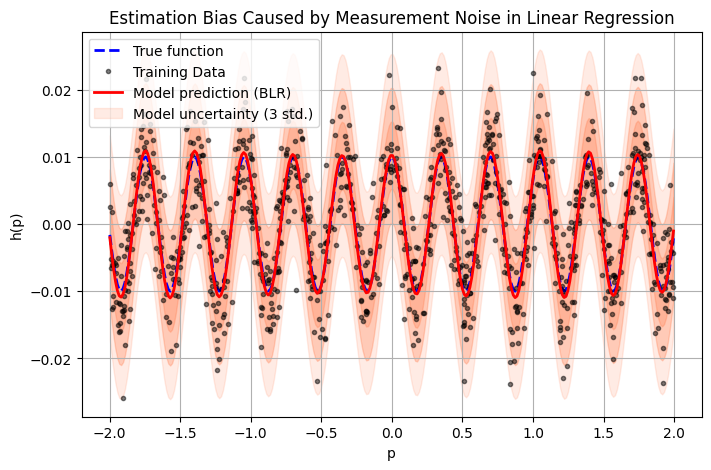

In [ ]:
# Generate the training data
np.random.seed(49) # for reproducibility
data_gen = GenerateData(num_samples=1000, case=case_real, param=terrain_param)
data_gen.set_noise(mean=0.0, std=sigma_prior) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Generate basis functions
basis, p_sym, basis_sym = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, 
                                                   min_poly_order, max_poly_order, min_freq, max_freq)

# Fit the model using linear regression
model_blr = Identifier_BLR(basis, sigma2=sigma_prior**2)
model_blr.fit(p, h)


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_blr.plot(true_func=true_func, title="Estimation Bias Caused by Measurement Noise in Linear Regression")


# Generate the symbolic expression for the learned model
h_func_blr, sigma2_h_func_blr = construct_casadi_expression(p_sym, basis_sym, model_blr.theta, model_blr.Sigma_theta, sigma_prior**2)


# Identified case for simulation
env_id = Env(case_real, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
                 symbolic_h_mean_ext=h_func_blr,  symbolic_h_cov_ext=sigma2_h_func_blr, param=terrain_param,
                 state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)
dynamics_id = Dynamics(env_id)


Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_LBMPC.so
rm -f acados_solver_LBMPC.o
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o acados_solver_LBMPC.o acados_solver_LBMPC.c
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o LBMPC_model/LBMPC_expl_ode_fun.o LBMPC_model/LBMPC_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/acados/include -I/acados/include/acados -I/acados/include/blasfeo/include -I/acados/include/hpipm/include  -c -o LBMPC_model/LBMPC_expl_vde_forw.o LBMPC_model/LBMPC_expl_vde_forw.c
cc -fPIC -std=c99   -O2 -I/acad

AttributeError: 'str' object has no attribute 'state_traj'

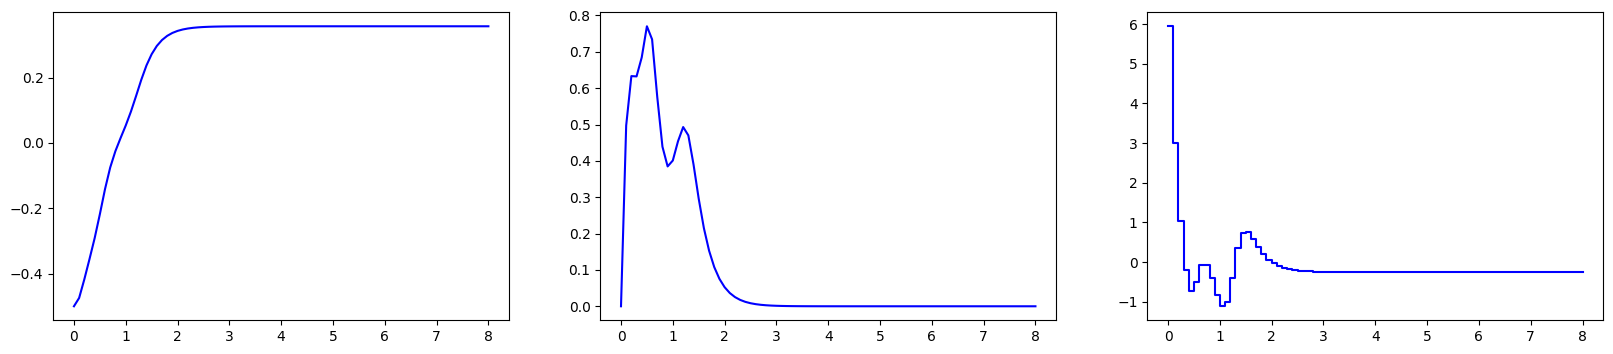

In [ ]:
# Define the LBMPC controller
controller_lbmpc = LearningBasedMPCController(env_id, dynamics_id, Q, R, Qf, N, freq, name='LBMPC')

# Instantiate the simulator, run the simulation, and plot the results
simulator_lbmpc = Simulator(dynamics_real, controller_lbmpc, env_real, 1/freq, t_terminal)
simulator_lbmpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_lbmpc = Visualizer(simulator_lbmpc)
visualizer_lbmpc.display_contrast_plots(simulator_rmpc, title='Performance Comparison: Learning-based MPC vs. RMPC with Flat Terrain Model')
visualizer_lbmpc.display_contrast_animation_same(simulator_rmpc)


#### **Results Analysis**

Compared to RMPC, LBMPC accurately reaches the target state, whereas RMPC only stabilizes within a neighborhood due to its conservative design. This performance gap arises because RMPC is based on a flat terrain model and fails to generate enough thrust to overcome the slope. In contrast, LBMPC captures the slope profile through Bayesian learning, enabling more informed predictions and tighter control actions. As a result, LBMPC achieves lower steady-state error and more efficient input usage under the same constraints.

<br>

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **💡 Take-away:**

- ✅ When the **true model is known**, classic model-based control performs optimally.  

- ⚠️ In practice, **model mismatch is unavoidable**. Naively reusing old controllers or applying RMPC with rough bounds often leads to failure (e.g., steady-state errors). 

- 🔍 **Learning a model from data** is key:

  - **Linear Regression (LR)** gives a deterministic approximation.

  - **Bayesian Linear Regression (BLR)** further captures uncertainty for safer control.
  
- 🚀 With a properly identified model, especially probabilistic ones, **Learning-Based MPC (LBMPC)** can restore near-optimal performance and enable **constraint tightening** under uncertainty.

</blockquote>
